In [1]:
import cv2
import selectivesearch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import selectivesearch
import numpy as np
import tensorflow as tf

/Users/arthurdercq/.pyenv/versions/3.10.6/envs/veggideas/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


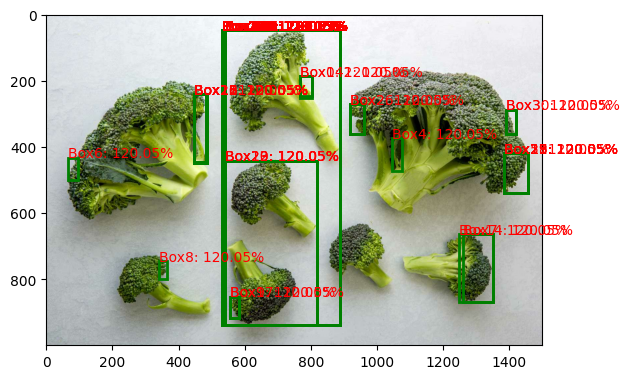

In [10]:

image_path = "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/brocolis.jpeg"

# Load the image with correct color channels
image = tf.image.decode_image(tf.io.read_file(image_path))


# Draw an empty figure
fig, ax = plt.subplots()

# Plot the image
ax.imshow(image)

# Perform selective search to generate candidate regions
selective_search_results = selectivesearch.selective_search(image, scale=750, sigma=0.99, min_size=10)
min_box_size = 1000

# Calculate target aspect ratio range (adjust as per your requirement)
target_aspect_ratio = 0.30
aspect_ratio_range = 0.35

selected_boxes = []
for region in selective_search_results[1]:
    x, y, w, h = region['rect']
    if w * h >= min_box_size:
        aspect_ratio = float(w) / h
        if abs(aspect_ratio - target_aspect_ratio) <= aspect_ratio_range:
            selected_boxes.append((x, y, x + w, y + h))

rect = []
for i, (x, y, x2, y2) in enumerate(selected_boxes):
    rect.append(patches.Rectangle((x, y), x2 - x, y2 - y, edgecolor='green', facecolor='none', linewidth=2))
    ax.add_patch(rect[i])

    ax.text(x, y, f'Box{i}: {round((aspect_ratio - target_aspect_ratio) * 100, 2)}%', color='red')

# Show the figure
plt.show()


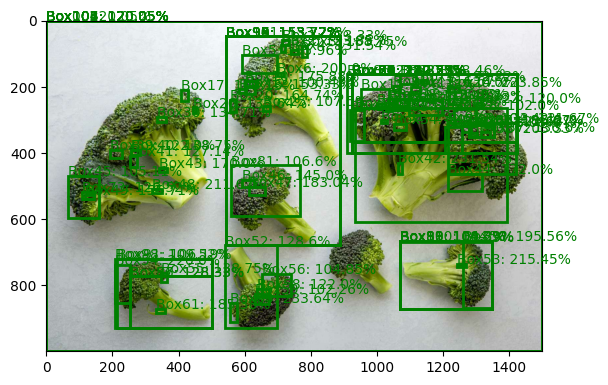

In [11]:

image_path = "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/brocolis.jpeg"

# Load the image with correct color channels
image = tf.image.decode_image(tf.io.read_file(image_path))

# Draw an empty figure
fig, ax = plt.subplots()
# Plot the image
ax.imshow(image)

selective_search_results = selectivesearch.selective_search(image, scale=750, sigma=0.9, min_size=100)

objectness_score_threshold = 0.9
minimum_bounding_box_size = 100
maximum_aspect_ratio = 3
# Calculate target aspect ratio range (adjust as per your requirement)
target_aspect_ratio = 0.30
aspect_ratio_range = 0.30

selected_candidates = []
for candidate in selective_search_results[1]:
    x, y, w, h = candidate['rect']

    # Calculate bounding box size and aspect ratio
    bounding_box_size = w * h
    aspect_ratio = max(w / h, h / w)

    # Check objectness score, bounding box size, and aspect ratio
    if (
        bounding_box_size >= minimum_bounding_box_size
        and aspect_ratio <= maximum_aspect_ratio
        and (aspect_ratio - target_aspect_ratio) * 100 > 100
    ):
        selected_candidates.append(candidate)

rect = []
for i, candidate in enumerate(selected_candidates):
    x, y, w, h = candidate['rect']
    rect.append(patches.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=2))
    ax.add_patch(rect[i])

    aspect_ratio = max(w / h, h / w)
    ax.text(x, y, f'Box{i}: {round((aspect_ratio - target_aspect_ratio) * 100, 2)}%', color='green')

# Show the figure
plt.show()

In [4]:
from veggideas.registry import load_model

model = load_model()


Load latest model from GCS...
Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-06-14 14:08:43.414781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-14 14:08:43.414892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


✅ Latest model downloaded from cloud storage


In [105]:
image_path = '/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/pump.jpg'

# Load the image
#image = cv2.imread(image_path)
image = tf.image.decode_image(tf.io.read_file(image_path))

# Perform selective search to generate candidate regions
selective_search_results = selectivesearch.selective_search(image, scale=750, sigma=0.9, min_size=100)

minimum_bounding_box_size = 100
maximum_aspect_ratio = 3
# Calculate target aspect ratio range (adjust as per your requirement)
target_aspect_ratio = 1
aspect_ratio_range = 0.30

selected_candidates = []
for i, candidate in enumerate(selective_search_results[1]):
    x, y, w, h = candidate['rect']

    # Calculate bounding box size and aspect ratio
    bounding_box_size = w * h
    aspect_ratio = max(w / h, h / w)

    # Exclude the bounding box of the whole picture
    image_size = image.shape[0] * image.shape[1]
    box_coverage = bounding_box_size / image_size
    if box_coverage < 0.98 and bounding_box_size >= minimum_bounding_box_size and aspect_ratio <= maximum_aspect_ratio:
        selected_candidates.append({'rect': (x, y, w, h), 'index': i})


# Function to calculate the coverage ratio between two bounding boxes
def calculate_coverage_ratio(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersection_x = max(x1, x2)
    intersection_y = max(y1, y2)
    intersection_w = min(x1 + w1, x2 + w2) - intersection_x
    intersection_h = min(y1 + h1, y2 + h2) - intersection_y

    intersection_area = max(0, intersection_w) * max(0, intersection_h)
    box1_area = w1 * h1
    box2_area = w2 * h2

    return intersection_area / box1_area, box1_area, box2_area

# List to store the filtered bounding boxes
filtered_boxes = []

# Iterate through the selected bounding boxes
for i in range(len(selected_candidates)):
    current_box = selected_candidates[i]['rect']
    is_contained = False

    # Check if the coverage ratio of the current box is less than 90% of any other box
    for j in range(len(selected_candidates)):
        if i != j:
            other_box = selected_candidates[j]['rect']
            coverage_ratio, current_area, other_area = calculate_coverage_ratio(current_box, other_box)
            if coverage_ratio >= 1:
                # The current box is contained within another box
                is_contained = True
                if current_area >= other_area:
                    filtered_boxes.append(current_box)
                else:
                    break
    # If the current box is not contained, add it to the filtered list
    if not is_contained:
        filtered_boxes.append(current_box)


unique_tuples = set(filtered_boxes)
filtered_list = list(unique_tuples)


# # # Create a figure and axes
# fig, ax = plt.subplots()

# # Plot the image
# ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# rect = []
# for i, box in enumerate(filtered_list):
#      x, y, w, h = box
#      rect.append(patches.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=2))
#      ax.add_patch(rect[i])

#      aspect_ratio = max(w / h, h / w)
#      ax.text(x, y, f'Box{i}: {round((aspect_ratio - target_aspect_ratio) * 100, 2)}%', color='green')

# # # Show the figure
# plt.show()

In [106]:
list_subimages =[]
cropped_images = []
# Itérer sur les coordonnées filtrées
for coords in filtered_list:
    
    x, y, w, h = coords

    # Extraire l'image à partir des coordonnées
    cropped_image = image[y:y+h, x:x+w]
    resized_image = tf.image.resize(cropped_image, (224, 224))
    final_image = np.expand_dims(resized_image, axis=0)
    list_subimages.append(final_image)
    cropped_images.append(cropped_image)
    
len(list_subimages)

46

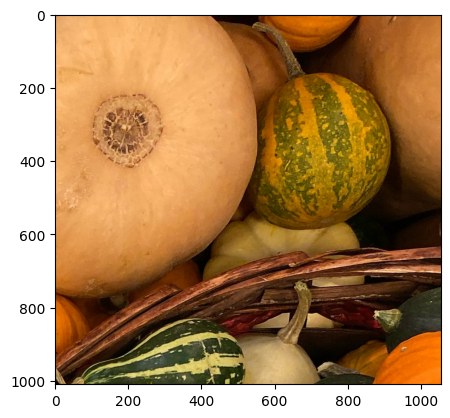

In [109]:
plt.imshow(cropped_images[40])

In [110]:
vegg_list = ['Bean', 'Broccoli','Cabbage', 'Capsicum', 
             'Carrot', 'Cauliflower', 'Cucumber',
                'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

predictions = {}
for image in list_subimages:
    prediction = model.predict(image)

    pred_class = np.argmax(prediction, axis=-1)[0]

    accuracy = np.max(prediction, axis=-1)[0]

    final_prediction = vegg_list[pred_class].lower()

    predictions[final_prediction] = accuracy
    

1/1 [==============================] - 0s 33ms/step


In [111]:
predictions

{'pumpkin': 0.9946357,
 'bean': 0.50191087,
 'potato': 0.5706407,
 'papaya': 0.97792727,
 'broccoli': 0.92580765}

In [113]:
def filter_predictions(predictions, threshold):
    filtered_predictions = {}
    for key, value in predictions.items():
        if value >0.98:
            filtered_predictions[key] = value
            return filtered_predictions
        if value > threshold:
            filtered_predictions[key] = value
        return filtered_predictions

filter_predictions(predictions, 0.8)

{'pumpkin': 0.9946357}

In [28]:
def most_frequent(list):
    counter = 0
    num = list[0]
     
    for i in list:
        curr_frequency = list.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num
 
most_frequent(predictions)

'cabbage'

In [30]:
list_images= ["/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/broccoli.jpg",
                  "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/brocolis.jpeg",
                  "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/capsicums.jpeg",
                  "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/carrot_couli.jpeg",
                  "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/carrots.jpeg",
                  "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/chou.jpeg",
                  "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/cucumber.jpeg",
                  "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/different_veggies.jpeg",
                  "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/patates.jpeg",
                  "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/pumkins.jpeg",
                  "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/pumpkin.jpeg",
                  "/Users/arthurdercq/code/ArthurDercq/veggideas/raw_data/testing_images/tomato.png"]

In [ ]:
image_path = '/Users/arthurdercq/Desktop/eggplants.jpeg'
image = cv2.imread(image_path)
plt.imshow(image)

In [ ]:
image_path = '/Users/arthurdercq/Desktop/eggplants.jpeg'
# Load the image
image = cv2.imread(image_path)
# Perform selective search to generate candidate regions
selective_search_results = selectivesearch.selective_search(image, scale=750, sigma=0.8, min_size=100)
minimum_bounding_box_size = 80
maximum_aspect_ratio = 3
# Calculate target aspect ratio range (adjust as per your requirement)
target_aspect_ratio = 0.6
aspect_ratio_range = 0.6
selected_candidates = []
for i, candidate in enumerate(selective_search_results[1]):
    x, y, w, h = candidate['rect']
    if w != 0 and h !=0:
    # Calculate bounding box size and aspect ratio
        bounding_box_size = w * h
        aspect_ratio = max(w / h, h / w)
    
    else:
        bounding_box_size = 1
        aspect_ratio = 100
    # Exclude the bounding box of the whole picture
    image_size = image.shape[0] * image.shape[1]
    box_coverage = bounding_box_size / image_size
    if box_coverage < 0.98 and bounding_box_size >= minimum_bounding_box_size and aspect_ratio <= maximum_aspect_ratio:
        selected_candidates.append({'rect': (x, y, w, h), 'index': i})
# Function to calculate the coverage ratio between two bounding boxes
def calculate_coverage_ratio(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    intersection_x = max(x1, x2)
    intersection_y = max(y1, y2)
    intersection_w = min(x1 + w1, x2 + w2) - intersection_x
    intersection_h = min(y1 + h1, y2 + h2) - intersection_y
    intersection_area = max(0, intersection_w) * max(0, intersection_h)
    box1_area = w1 * h1
    box2_area = w2 * h2
    return intersection_area / box1_area, box1_area, box2_area
# List to store the filtered bounding boxes
filtered_boxes = []
# Iterate through the selected bounding boxes
for i in range(len(selected_candidates)):
    current_box = selected_candidates[i]['rect']
    is_contained = False
    smol = False
    # Check if the coverage ratio of the current box is less than 90% of any other box
    for j in range(len(selected_candidates)):
        if i != j:
            other_box = selected_candidates[j]['rect']
            coverage_ratio, current_area, other_area = calculate_coverage_ratio(current_box, other_box)
            if coverage_ratio >= 0.5 and current_area < other_area:
                # The current box is contained within another box
                smol = True
                break
    # If the current box is not contained, add it to the filtered list
    if not smol:
        filtered_boxes.append(current_box)
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the image
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
rect = []
for i, box in enumerate(filtered_boxes):
    x, y, w, h = box
    rect.append(patches.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=2))
    ax.add_patch(rect[i])
    aspect_ratio = max(w / h, h / w)
    ax.text(x, y, f'Box{i}: {round((aspect_ratio - target_aspect_ratio) * 100, 2)}%', color='green')
# Show the figure
plt.show()